In [1]:
import torch
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from safetensors.torch import load_file
from esm.models.esm3 import ESM3
from transformers import AutoModel
from esm.sdk.api import ESMProtein, GenerationConfig, LogitsConfig
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve
from scipy.interpolate import make_interp_spline

/home/av47/miniconda3/envs/esm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model = ESM3.from_pretrained("esm3-open", device=torch.device("cuda:2"))
finetuned_model = ESM3.from_pretrained("esm3-open", device=torch.device("cuda:2"))

Fetching 22 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 40524.68it/s]
/home/av47/miniconda3/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

In [3]:
def load_weights(path, model):
    state_dict = torch.load(path, map_location="cuda:2")
    new_dict = {}
    
    for k, v in state_dict.items():
        if k in model.state_dict():
            new_dict[k] = v
    model.load_state_dict(new_dict)

In [4]:
load_weights("weights/20241201-144617/checkpoint-46362/pytorch_model.bin", finetuned_model)

/tmp/ipykernel_3910466/919341665.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="cuda:2")


In [5]:
def get_embeddings(model, seq):
    full_seq = f"EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYC{seq}WGQGTLVTVSS"
    protein = ESMProtein(sequence=full_seq)
    protein_tensor = model.encode(protein)
    logits = model.logits(protein_tensor, LogitsConfig(sequence=True, return_embeddings=True))
    return torch.mean(logits.embeddings[:,96:106].squeeze(0), dim=0)

In [6]:
train_df = pd.read_csv("data/dpo/holdout/dpo_train_data.csv")
seq_df = pd.read_csv("data/all.csv")
seqs = set(train_df.chosen.tolist() + train_df.rejected.tolist())
all_seqs = seq_df[seq_df.label == 1].seq.tolist() + seq_df[seq_df.label == 0].seq.tolist()
test_seqs = set(all_seqs) - seqs

In [7]:
test_df = seq_df[seq_df["seq"].isin(test_seqs)]
sampled_seqs = (
    test_df.groupby("cluster_centre")
    .apply(lambda group: group.loc[group["edit_distance"].idxmin()])
    .reset_index(drop=True)
)
len(sampled_seqs)

/tmp/ipykernel_3910466/821908983.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.loc[group["edit_distance"].idxmin()])


12430

In [8]:
emb_df = seq_df[seq_df["seq"].isin(seqs)]
emb_sampled_seqs = (
    emb_df.groupby("cluster_centre")
    .apply(lambda group: group.loc[group["edit_distance"].idxmin()])
    .reset_index(drop=True)
)
len(emb_sampled_seqs)

/tmp/ipykernel_3910466/526274165.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.loc[group["edit_distance"].idxmin()])


8992

In [9]:
test_positive_seqs = sampled_seqs[sampled_seqs["label"] == 1].seq.tolist()
test_negative_seqs = sampled_seqs[sampled_seqs["label"] == 0].seq.tolist()

emb_positive_seqs = emb_sampled_seqs[emb_sampled_seqs["label"] == 1].seq.tolist()
emb_negative_seqs = emb_sampled_seqs[emb_sampled_seqs["label"] == 0].seq.tolist()

In [10]:
finetuned_positive_embeddings = torch.stack([get_embeddings(finetuned_model, seq) for seq in tqdm(emb_positive_seqs)])
finetuned_negative_embeddings = torch.stack([get_embeddings(finetuned_model, seq) for seq in tqdm(emb_negative_seqs)])

base_positive_embeddings = torch.stack([get_embeddings(base_model, seq) for seq in tqdm(emb_positive_seqs)])
base_negative_embeddings = torch.stack([get_embeddings(base_model, seq) for seq in tqdm(emb_negative_seqs)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5612/5612 [03:48<00:00, 24.59it/s]


In [11]:
finetuned_positive_center = torch.mean(finetuned_positive_embeddings, dim=0)
finetuned_negative_center = torch.mean(finetuned_negative_embeddings, dim=0)

base_positive_center = torch.mean(base_positive_embeddings, dim=0)
base_negative_center = torch.mean(base_negative_embeddings, dim=0)

labels = ([1] * len(test_positive_seqs)) + ([0] * len(test_negative_seqs))
finetuned_pred_labels = []
base_pred_labels = []

for seq in tqdm(test_positive_seqs):
    finetuned_test_emb = get_embeddings(finetuned_model, seq)
    base_test_emb = get_embeddings(base_model, seq)
    
    finetuned_positive_dist = torch.sqrt(torch.sum((finetuned_positive_center-finetuned_test_emb)**2)).item()
    finetuned_negative_dist = torch.sqrt(torch.sum((finetuned_negative_center-finetuned_test_emb)**2)).item()

    base_positive_dist = torch.sqrt(torch.sum((base_positive_center-base_test_emb)**2)).item()
    base_negative_dist = torch.sqrt(torch.sum((base_negative_center-base_test_emb)**2)).item()
    
    if finetuned_positive_dist < finetuned_negative_dist:
        finetuned_pred_labels.append(1)
    else:
        finetuned_pred_labels.append(0)

    if base_positive_dist < base_negative_dist:
        base_pred_labels.append(1)
    else:
        base_pred_labels.append(0)

for seq in tqdm(test_negative_seqs):
    finetuned_test_emb = get_embeddings(finetuned_model, seq)
    base_test_emb = get_embeddings(base_model, seq)
    
    finetuned_positive_dist = torch.sqrt(torch.sum((finetuned_positive_center-finetuned_test_emb)**2)).item()
    finetuned_negative_dist = torch.sqrt(torch.sum((finetuned_negative_center-finetuned_test_emb)**2)).item()

    base_positive_dist = torch.sqrt(torch.sum((base_positive_center-base_test_emb)**2)).item()
    base_negative_dist = torch.sqrt(torch.sum((base_negative_center-base_test_emb)**2)).item()
    
    if finetuned_positive_dist < finetuned_negative_dist:
        finetuned_pred_labels.append(1)
    else:
        finetuned_pred_labels.append(0)

    if base_positive_dist < base_negative_dist:
        base_pred_labels.append(1)
    else:
        base_pred_labels.append(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8679/8679 [11:52<00:00, 12.18it/s]


Text(0, 0.5, 'True Positive Rate')

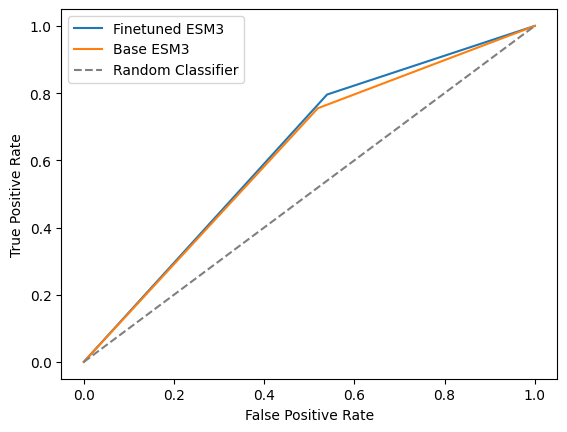

In [16]:
finetuned_fpr, finetuned_tpr, _ = roc_curve(labels, finetuned_pred_labels)
base_fpr, base_tpr, _ = roc_curve(labels, base_pred_labels)

# Step 4: Plot the ROC curve
# plt.figure()
sns.lineplot(x=finetuned_fpr, y=finetuned_tpr, label="Finetuned ESM3")
sns.lineplot(x=base_fpr, y=base_tpr, label="Base ESM3")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="gray", label="Random Classifier")

# Add labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

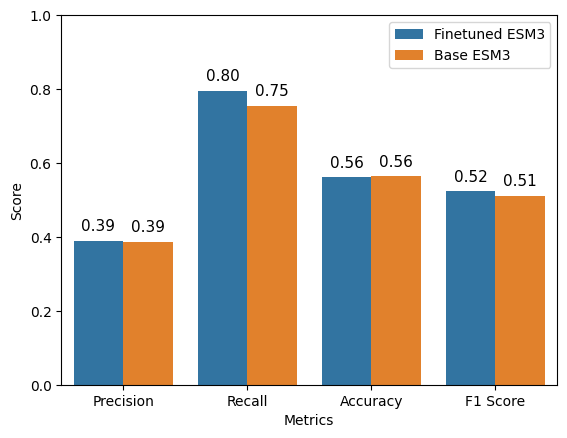

In [31]:
# Calculate precision, recall, accuracy, and F1 scores for finetuned model
finetuned_precision = precision_score(labels, finetuned_pred_labels)
finetuned_recall = recall_score(labels, finetuned_pred_labels)
finetuned_accuracy = accuracy_score(labels, finetuned_pred_labels)
finetuned_f1 = f1_score(labels, finetuned_pred_labels)

# Calculate precision, recall, accuracy, and F1 scores for base model
base_precision = precision_score(labels, base_pred_labels)
base_recall = recall_score(labels, base_pred_labels)
base_accuracy = accuracy_score(labels, base_pred_labels)
base_f1 = f1_score(labels, base_pred_labels)

metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
finetuned_scores = [finetuned_precision, finetuned_recall, finetuned_accuracy, finetuned_f1]
base_scores = [base_precision, base_recall, base_accuracy, base_f1]

data = {
    'Metric': metrics * 2,
    'Score': finetuned_scores + base_scores,
    'Model': ['Finetuned ESM3'] * len(metrics) + ['Base ESM3'] * len(metrics)
}

df = pd.DataFrame(data)
ax = sns.barplot(x='Metric', y='Score', hue='Model', data=df)

plt.ylabel('Score')
plt.xlabel('Metrics')

plt.ylim(0, 1)

# Add value labels on top of the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Condition to exclude bars with height 0
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Show the legend
plt.legend()

/tmp/ipykernel_3888504/391473494.py:26: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.gca().annotate(f'{height:.2f}',


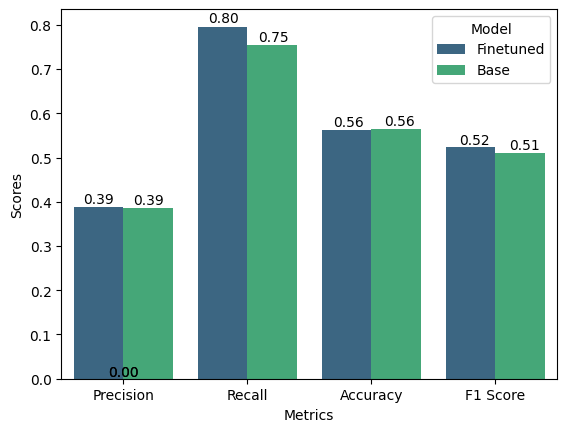

In [122]:
def calculate_metrics(true_labels, pred_labels):
    return {
        "Precision": precision_score(true_labels, pred_labels),
        "Recall": recall_score(true_labels, pred_labels),
        "Accuracy": accuracy_score(true_labels, pred_labels),
        "F1 Score": f1_score(true_labels, pred_labels)
    }

finetuned_metrics = calculate_metrics(labels, finetuned_pred_labels)
base_metrics = calculate_metrics(labels, base_pred_labels)

# Prepare data in long format
data = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"] * 2,
    "Score": list(finetuned_metrics.values()) + list(base_metrics.values()),
    "Model": ["Finetuned"] * 4 + ["Base"] * 4
}

df = pd.DataFrame(data)

# Plot using Seaborn
sns.barplot(x="Metric", y="Score", hue="Model", data=df, palette="viridis")

# Add annotations
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height:.2f}',
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5),
                      textcoords='offset points')

# Customize the plot
plt.title("Comparison of Metrics Between Finetuned and Base Models", fontsize=16)
plt.ylabel("Scores", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
# plt.ylim(0, 1.1)  # Assuming scores are between 0 and 1
plt.legend(title='Model')
plt.tight_layout()

# Show plot
plt.show()